In [5]:
import json
import re
from pymatgen.core import Composition, Element
import pprint as pp
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle as pkl
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import sys, os
sys.path.append('/home/jupyter/CJK/TempTime')
from data_extraction_rxn_classification_all_targets import *

In [6]:
all_elements = [Element.from_Z(i).symbol for i in range(1, 119)]

In [7]:
with open('/home/jupyter/CJK/TempTime/data/solid-state_dataset_20200713.json') as f:
    ss_data= json.load(f)
ss_reactions = ss_data["reactions"]
ss_extracted, ss_precursor_nomenclature = extract_solidstate(ss_reactions, max_pre=5)

Returning extracted data of 51574/31782 reactions.


In [8]:
with open('/home/jupyter/CJK/TempTime/data/ss_extracted_NO_IMPUTATION_precs_all_targets.pkl', 'rb') as f:
    papers = pkl.load(f)

In [9]:
papers = [x for x in papers if not np.isnan(x['temp_time_vector'][0])]

In [10]:
papers

[{'DOI': '10.1149/1.1614797',
  'target': 'LiTi0.05Ni0.95O2',
  'precursors': ['LiHO', 'Ni(HO)2', 'TiO2'],
  'operation_types': ['StartingSynthesis',
   'MixingOperation',
   'HeatingOperation',
   'HeatingOperation'],
  'operation_tokens': ['prepared', 'ballmilled', 'calcined', 'heated'],
  'operation_times': [None, 24, None, None],
  'operation_temps': [None, None, 550.0, 750.0],
  'temp_time_vector': array([550.,  nan,  nan,  nan,  nan,  nan,  nan,  nan])},
 {'DOI': '10.1149/1.3153142',
  'target': 'Sr3SmP3O12',
  'precursors': ['PH9(NO2)2', 'Sm2O3', 'SrCO3'],
  'operation_types': ['StartingSynthesis',
   'MixingOperation',
   'MixingOperation',
   'HeatingOperation',
   'QuenchingOperation',
   'MixingOperation',
   'HeatingOperation',
   'MixingOperation',
   'HeatingOperation',
   'QuenchingOperation'],
  'operation_tokens': ['prepared',
   'mixed',
   'ground',
   'heated',
   'quenched',
   'mixed',
   'heated',
   'milling',
   'calcined',
   'cooled'],
  'operation_times': [N

In [11]:
targets = [x['target'] for x in papers]
precursors = [x['precursors'] for x in papers]
temps = [x['temp_time_vector'][0] for x in papers]
dois = [x['DOI'] for x in papers]

In [12]:
# get means
only_ss_rxns = []
for target, precs, temps, doi in zip(targets, precursors, temps, dois):
    if len(precs) == 0:
        continue
    found = False
    for result in only_ss_rxns:
        if result["target"] == target and set(result["precursors"]) == set(precs):
            result["ss_sinter_temps"].append(temps)
            result["DOIs"].append(doi)
            found = True
    if not found:
        new_result = {}
        new_result["target"] = target
        new_result["precursors"] = precs
        new_result["ss_sinter_temps"] = [temps]
        new_result["DOIs"] = [doi]
        only_ss_rxns.append(new_result)

In [13]:
with open('/home/jupyter/CJK/TempTime/rxn_classification_fraction/data/full_mp.json', 'r') as f:
    full_mp = json.load(f)

In [17]:
full_mp = {Composition(x): full_mp[x] for x in full_mp}
full_mp_median = np.median(list(full_mp.values()))

In [18]:
# change precursor functional groups back
for rxn in only_ss_rxns:
    for i in range(len(rxn['precursors'])):
        rxn['precursors'][i] = ss_precursor_nomenclature[Composition(rxn['precursors'][i])]

In [21]:
temps = []
for rxn in only_ss_rxns:
    mps = [full_mp.get(Composition(x), full_mp_median) for x in rxn["precursors"]]
    min_temp = min(mps)
    min_23 = (2/3)*min_temp
    temps.append([np.mean(rxn['ss_sinter_temps']), min_temp, min_23])

In [22]:
preds = [rxn[2] for rxn in temps]
real_temps = [rxn[0] for rxn in temps]

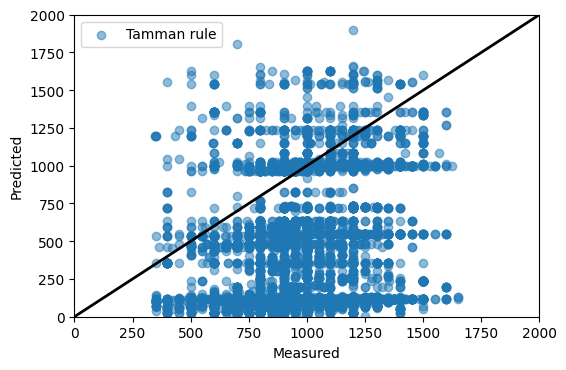

In [23]:
fig, ax = plt.subplots(dpi=100)
ax.scatter(real_temps, preds, alpha=0.5, label="Tamman rule")
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.legend()
ax.plot([0, 2000], [0, 2000], "k-", lw=2)
ax.set_xlim([0, 2000])
ax.set_ylim([0, 2000])
plt.show()

In [27]:
real_temps = np.array(real_temps)
preds = np.array(preds)
mae = mean_absolute_error(real_temps, preds)
rmse = mean_squared_error(real_temps, preds, squared=False)
r2 = r2_score(real_temps, preds)
mre = np.mean((np.abs(preds-real_temps)/real_temps)*100)

In [28]:
print('Number of samples with all precursor MPs tabulated: {}'.format(len(temps)))
print('RMSE: {}'.format(rmse))
print('MAE: {}'.format(mae))
print('MRE {}'.format(mre))
print('R2 score: {}'.format(r2))

Number of samples with all precursor MPs tabulated: 12228
RMSE: 724.5559760349876
MAE: 646.2589849712582
MRE 66.05189806994835
R2 score: -10.532308967031144


In [37]:
papers_with_sinter_calcine = [x for x in papers if not np.isnan(x['temp_time_vector'][0]) and not np.isnan(x['temp_time_vector'][1])]

In [42]:
all_diffs = []
for paper in papers_with_sinter_calcine:
    all_diffs.append(paper['temp_time_vector'][1] - paper['temp_time_vector'][0])
print(np.average(all_diffs))

225.99592266210706
